In [1]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist
from scipy import signal

#plots
import pylab as plt
import matplotlib.pyplot as plt
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)

In [8]:
df1 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/NotWindyMA.h5')

In [6]:
import matplotlib.image as mpimg

### Low Pass Filter Design

In [12]:
# cf=1/(df1.master_time[1]-df1.master_time[0])
fs=200
nyq=fs*0.5
cutoff_freq=40

sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
filtered = signal.sosfilt(sos, df1.odor)
dt = df1.master_time[1]-df1.master_time[0]

time = []
time.append(0)
for i in range(1,len(df1)):
    time.append(time[i-1]+dt)
df1['time'] = time

df1['filtered_odor']=filtered

dir='~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Windy/HW'+str(cutoff_freq)+'Hz.h5'
df1.to_hdf(dir, key='df1', mode='w')
# filtered = signal.lfilter(b, a, df1.odor)
# df1['filtered_odor']=filtered

### DataFrame Cleanup

In [48]:
## Removing points near 2 meters

# df1.drop(df1[df1['distance_from_source'] < 2].index, inplace = True)

# df1 = df1.drop(columns=['sync_time'])

time = []
time.append(0)
for i in range(1,len(df1)):
    time.append(time[i-1]+dt)
df1['time'] = time

# sync_time = df1.master_time-df1.master_time[0]
# df1['sync_time']=df.time

# dt = df1.master_time[1]-df1.master_time[0]
# df1 = df1.drop(columns=['filtered_odor'])
df1['filtered_odor']=filtered

## Removing points close to the source by 2 meters
# df1.drop(df1[df1['distance_from_source'] < 2].index, inplace = True)

In [49]:
dir='~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Windy/HW80Hz.h5'
df1.to_hdf(dir, key='df1', mode='w')

### Extracting Continuous Streakline

In [9]:
#pass time res and extract the continuous streakline

time_res=2002*5 ## 500 for lowres 
range_points = []
start_angle=df1.D[0]
range_points.append(0)
i = 0        
while i < (len(df1)):
    diff = np.abs(df1.D[i] - start_angle)
    if diff >= 70:
        range_points.append(i)
        start_angle=df1.D[i+time_res]
        i+=time_res
    else:
        i+=1
        continue

In [10]:
cs=pd.DataFrame()
j = 0
while j < (len(range_points)):
#     print(i)
    if(j < len(range_points)-1):
        cs = cs.append(df1[range_points[j]:range_points[j+1]])        
    else:
        cs = cs.append(df1[range_points[j]:])
    j+=2
cs.reset_index(inplace=True, drop=True) 


In [11]:
## removing the above 
# df1.drop(df1.loc[(df1['sync_time'] >= 1545) & (df1['sync_time'] <= 2290)].index,inplace=True) 
# df1 = df1.drop(columns=['sync_time'])

## count the new sync_time
dt= df1.master_time[1]-df1.master_time[0]
time = []
time.append(0)
for i in range(1,len(cs)):
    time.append(time[i-1]+dt)

cs['time'] = time

cs.reset_index(inplace=True, drop=True) 

In [12]:
dir='~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/NotWindyC70.h5'
cs.to_hdf(dir, key='cs', mode='w')

## Distance Mapping Plots All Terrain

In [2]:
df1 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Windy/WindyMASigned.h5')
df2 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Forest/ForestMASigned.h5')

In [4]:
q='odor>4.5'
dfdist1=df1.query(q)
dfdist2=df2.query(q)
dfdist3=df3.query(q)

In [5]:
dataframes=[dfdist1,dfdist2,dfdist3]

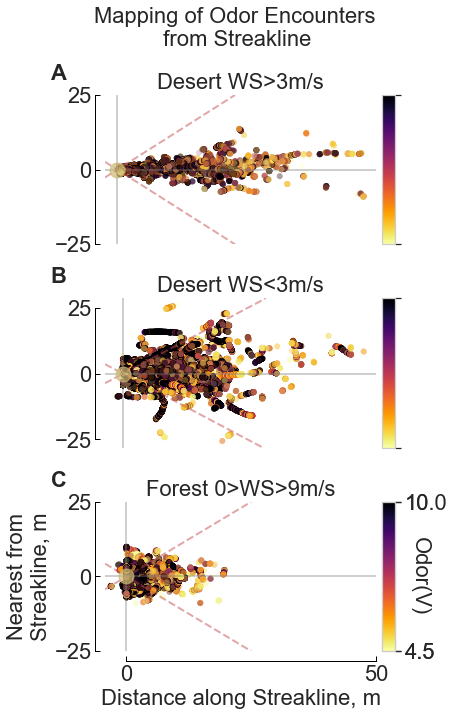

In [45]:
import string
f,(ax)=plt.subplots(3,1,figsize=(6,10))

ax[2].set_ylabel('Nearest from\nStreakline, m')
ax[2].set_xlabel('Distance along Streakline, m')
f.suptitle("Mapping of Odor Encounters\n from Streakline")
for i in range(len(dataframes)):

    var = ax[i].scatter(dataframes[i].distance_from_source_a*dataframes[i].xsign,
                        dataframes[i].nearest_from_streakline*dataframes[i].ysign,
                        c=dataframes[i].odor, cmap="inferno_r",
               edgecolors='none', alpha=0.2, vmin=4.5, vmax=10)
    ax[i].grid(False)
    ax[i].axline((0,0),slope=1, linestyle='dashed', linewidth=2, color='r', alpha=0.5)
    ax[i].axline((0, 0), slope=-1, linestyle='dashed', linewidth=2, color='r', alpha=0.5)
    ax[i].axhline(0, color = 'grey', alpha=0.5)
    ax[i].axvline(0, color = 'grey', alpha=0.5)
    ax[i].plot(0,0,marker='o',  c='y', markersize=15, alpha=0.7)
    mpl_functions.adjust_spines(ax[i],['left'],spine_locations={},
                            smart_bounds=True,yticks=[-25,0,25],linewidth=1)

    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.08)
    cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[4.5, 10])
    cbar.ax.set_yticklabels([])
#     cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=10)
    cbar.solids.set(alpha=1)
    
for i in range(len(dataframes)):
     ax[i].text(-0.2, 1.1, string.ascii_uppercase[i], transform=ax[i].transAxes,
            weight='bold')
        
ax[0].set_title('Desert WS>3m/s')
ax[1].set_title('Desert WS<3m/s')
ax[2].set_title('Forest 0>WS>9m/s')

# ax[0].text(0.1, 0.1, 'Slope=45deg', rotation=-45, ha='center',fontsize=18,c='r')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[4.5, 10])
cbar.ax.set_yticklabels(['4.5','10'])
cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)
cbar.solids.set(alpha=1)

mpl_functions.adjust_spines(ax[2],['left', 'bottom'],spine_locations={},
                                smart_bounds=True, xticks=[0,50],yticks=[-25,0,25], linewidth=1)

f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 22)
f.savefig('../../Figure/DistanceMap.jpeg', dpi=300, bbox_inches = "tight")

## Find if there was direction change back in time for the above extracted points

In [4]:
df_occurence.insert(26,"slope",(df_occurence.nearest_from_streakline/df_occurence.distance_from_source))

In [11]:
q1 = 'slope>=0 & slope<0.08'
q2 = 'slope>=0.08 & slope<0.17'
q3 = 'slope>=0.17 & slope<0.27'
q4 = 'slope>=0.27 & slope<0.36'
q5 = 'slope>=0.36 & slope<0.46'
q6 = 'slope>=0.46 & slope<0.58'
q7 = 'slope>=0.58 & slope<0.7'
q8 = 'slope>=0.70 & slope<0.84'
q9 = 'slope>=0.84'

time_since_last_change_5 = []
time_since_last_change_10 = []
time_since_last_change_15 = []
time_since_last_change_20 = []
time_since_last_change_25 = []
time_since_last_change_30 = []
time_since_last_change_35 = []
time_since_last_change_40 = []
time_since_last_change_45 = []

In [28]:
df1=pd.DataFrame()
df1=df_occurence.query(q9)

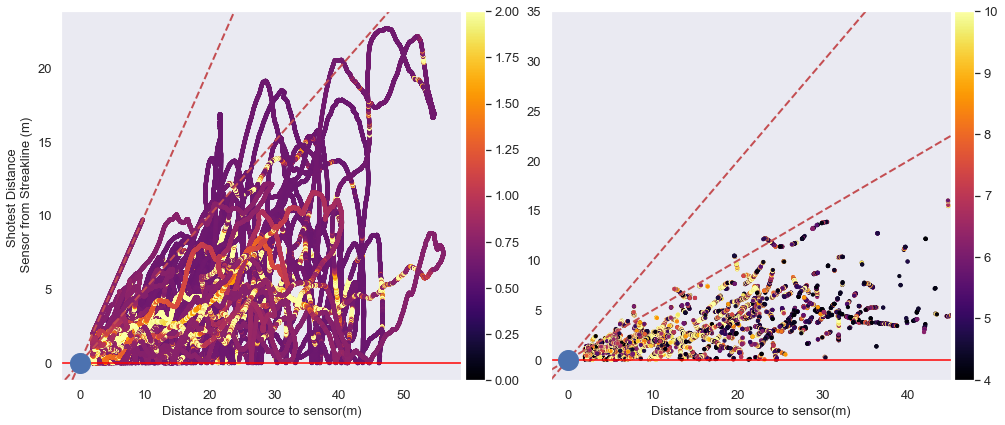

In [7]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6))
ax1.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax1.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax1.axhline(0, color = 'red')
ax1.grid(False)
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df1.distance_from_source, df1.nearest_from_streakline, cmap = 'inferno', 
                  c = df1.odor, label ='Odor_Not_Detected', vmin=0, vmax=2, s = 10)
# ax1.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', alpha= 0.5, 
#            extent=[x[0], x[-1], y[0], y[-1]])

ax1.set_xlabel('Distance from source to sensor(m)')
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')


ax2.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax2.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax2.axhline(0, color = 'red')
ax2.grid(False)
ax2.plot(0,0,'o', markersize = 20)

var2 = ax2.scatter(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, cmap = 'inferno', 
                  c = df_occurence.odor, vmin=4, vmax=10, s = 10)

ax2.set_xlabel('Distance from source to sensor(m)')
# ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')
ax2.set_xlim ([-2,45])
ax2.set_ylim([-2,35])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 13)
# f.savefig('../../Figure/locationalrepOdor.jpeg')

In [29]:
# 100 rows approx 10 seconds for low res
# 2002 rows approx 10 seconds for hi res
lookback_time = 2002 * 5
check_angle = 90
for i in range(0,len(df1.index)): 
    angle = np.abs(df.D[(df1.index[i]-lookback_time):df1.index[i]] 
                   - df.D[df1.index[i]])
    
    if (angle>check_angle).any() == True: 
        pos = np.where(angle >= check_angle)
        time_since_last_change_45.append((lookback_time-pos[-1][-1])/0.005) ## because each row is 1/10 seconds
        
    else:
        continue

In [30]:
df_time=pd.DataFrame()
df_time_1=pd.DataFrame()
df_time_2=pd.DataFrame()
df_time_3=pd.DataFrame()
df_time_4=pd.DataFrame()
df_time_5=pd.DataFrame()
df_time_6=pd.DataFrame()
df_time_7=pd.DataFrame()
df_time_8=pd.DataFrame()
df_time_9=pd.DataFrame()

df_time_1['duration'] = time_since_last_change_5
df_time_1['angle']=np.repeat('0-0.08°',len(time_since_last_change_5))

df_time_2['duration'] = time_since_last_change_10
df_time_2['angle']=np.repeat('0.08-0.17',len(time_since_last_change_10))

df_time_3['duration'] = time_since_last_change_15
df_time_3['angle']=np.repeat('0.17-0.27',len(time_since_last_change_15))

df_time_4['duration'] = time_since_last_change_20
df_time_4['angle']=np.repeat('0.27-0.36',len(time_since_last_change_20))

df_time_5['duration'] = time_since_last_change_25
df_time_5['angle']=np.repeat('0.36-0.46',len(time_since_last_change_25))

df_time_6['duration'] = time_since_last_change_30
df_time_6['angle']=np.repeat('0.46-0.58',len(time_since_last_change_30))

df_time_7['duration'] = time_since_last_change_35
df_time_7['angle']=np.repeat('0.58-0.7',len(time_since_last_change_35))

df_time_8['duration'] = time_since_last_change_40
df_time_8['angle']=np.repeat('0.70-0.84',len(time_since_last_change_40))

df_time_9['duration'] = time_since_last_change_45
df_time_9['angle']=np.repeat('> 0.84',len(time_since_last_change_45))

df_time=pd.concat([df_time_1,df_time_2, df_time_3, df_time_4, df_time_5, df_time_6, df_time_7, df_time_8, df_time_9],
                  ignore_index=True)

In [31]:
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# df_time.to_hdf(dir+'AngleDuration0102.h5', key='df_time', mode='w')

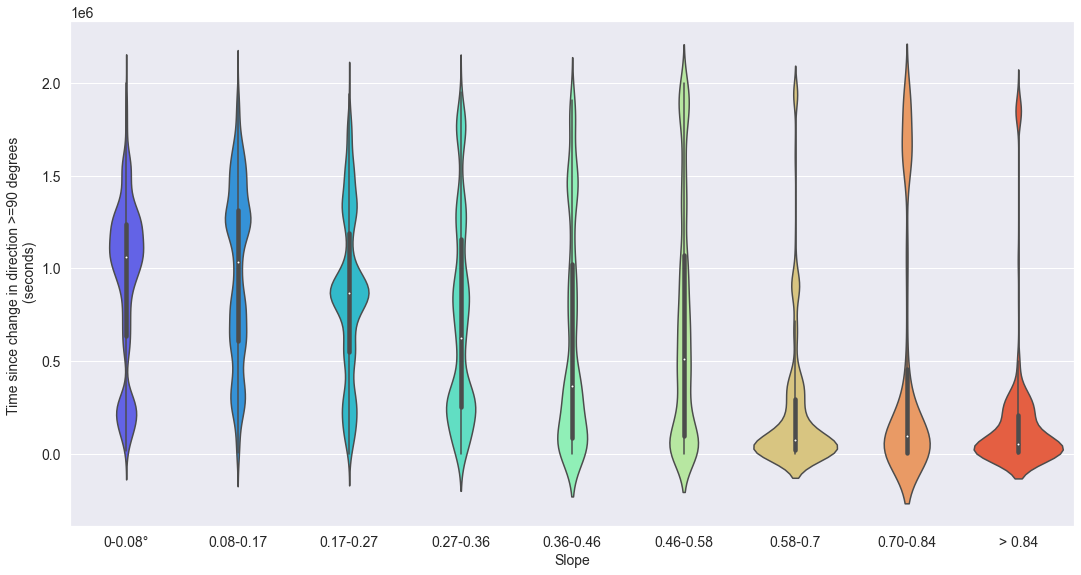

In [32]:
f, ax = plt.subplots(1,1, figsize=(15,8))
sns.violinplot(x='angle',y="duration", data=df_time, dodge='True', palette='rainbow')
# sns.boxplot(x="angle", y="duration", data=df_time,  dodge=True,  palette='viridis' )
# sns.catplot(x="angle", y="duration", data=df_time,  dodge=True,  palette='husl')
# sns.stripplot(x='angle', y='duration', data=df_time, dodge='True')

ax.set_xlabel('Slope')
ax.set_ylabel('Time since change in direction >=90 degrees \n (seconds)')
f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 14)
# f.savefig('../../Figure/timesincedirectionchange90HD.jpeg')

#### Find if there was a change in angle - output 0s and 1s

In [109]:
queryx='slope>0.57'
df2=pd.DataFrame()
df2 = df_occurence.query(queryx)

### BootStrap for Probability Significance

In [105]:
df_bootstrap_slopeless = pd.DataFrame()
df_bootstrap_slopemore = pd.DataFrame()
df_bootstrap=pd.DataFrame()

In [106]:
def prob_counter(index):
    for i in range(len(index)):
        if(index[i]<501):
            continue
        else:
            angle = np.abs(df.D[(index[i]-lookback_time):index[i]] - df.D[index[i]])
            if (angle>90).any() == True: 
                angle_changes_1.append(1)

            else: angle_changes_1.append(0)
            
    prob_yes.append(angle_changes_1.count(1)/(angle_changes_1.count(0)+angle_changes_1.count(1)))
    prob_no.append(angle_changes_1.count(0)/(angle_changes_1.count(0)+angle_changes_1.count(1)))
    

In [110]:
prob_yes=[]
prob_no=[]
angle_changes_1 = []
bootstrap_samples = 100
number_of_time = 500
lookback_time = 100*5
for i in range(number_of_time):
    index = np.random.choice(df2.index, size = bootstrap_samples)
    prob_counter(index)

In [48]:
# angle_changes_1 = []
# # 100 rows approx 10 seconds for low res
# # 2002 rows approx 10 seconds for hi res
# lookback_time = 100 * 5
# for i in range(0,len(df2.index)):
#     angle = np.abs(df.D[(df2.index[i]-lookback_time):df2.index[i]] - df.D[df2.index[i]])
#     if (angle>90).any() == True: angle_changes_1.append(1)
#     else: angle_changes_1.append(0)

In [111]:
df_bootstrap_slopemore['prob_of_direction_change'] = prob_yes
df_bootstrap_slopemore['slope']=np.repeat('slope>0.57',len(prob_yes))

In [108]:
df_bootstrap_slopeless['prob_of_direction_change'] = prob_yes
df_bootstrap_slopeless['slope']=np.repeat('slope<0.57',len(prob_yes))

In [112]:
df_bootstrap=pd.concat([df_bootstrap_slopemore,df_bootstrap_slopeless],
                  ignore_index=True)

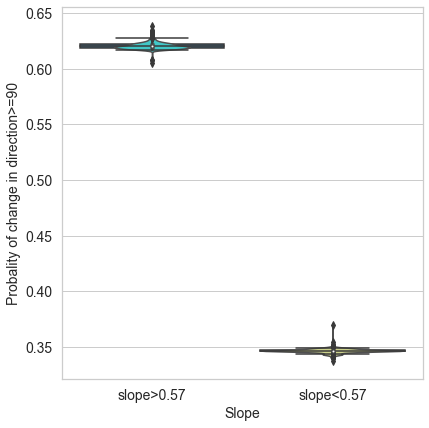

In [118]:
f, ax = plt.subplots(1,1, figsize=(6,6))
sns.violinplot(x="slope", y="prob_of_direction_change", data=df_bootstrap, dodge='True', palette='rainbow')
sns.boxplot(x="slope", y="prob_of_direction_change", data=df_bootstrap,  dodge=True,  palette='viridis' )
# sns.catplot(x="slope", y="prob_of_direction_change", data=df_bootstrap, dodge=True,  palette='husl')
# sns.stripplot(x="slope", y="prob_of_direction_change", data=df_bootstrap, dodge='True')
ax.set_xlabel('Slope')
ax.set_ylabel('Probality of change in direction>=90')
f.tight_layout()

figurefirst.mpl_functions.set_fontsize(f, 14)
f.savefig('../../Figure/probchangedirection.jpeg')